# Fine-tune SAM (segment Anything Model) on a Custom Dataset

This notebook we will fine-tune SAM (Segment Anything Model) on a custom dataset. Whether you're working on medical image analysis, satellite imagery, or any domain-specific segmentation task, the process of adapting a pre-trained model to your specific needs is a crucial step. In this tutorial we will use simple dataset, Road Pothole Segmentation with small image, but from this you can scaled up to larger dataset.


## Set-up environment

We first install 🤗 Transformers and 🤗 Datasets.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


## Load dataset

Here we load a small dataset of 84 (image, ground truth mask) pairs.

To load your own images and masks, you must upload your dataset to huggingface hub with following tutorials https://huggingface.co/docs/transformers/tasks/semantic_segmentation#custom-dataset.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("hf-vision/road-pothole-segmentation")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/79 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 79
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5
    })
})

We can visualize an example:

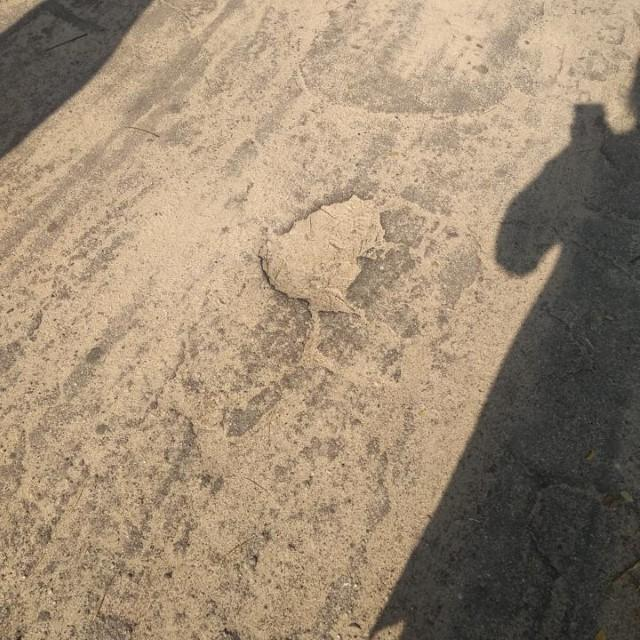

In [ ]:
example = dataset["train"][1]
example
image = example["image"]
image

(-0.5, 639.5, 639.5, -0.5)

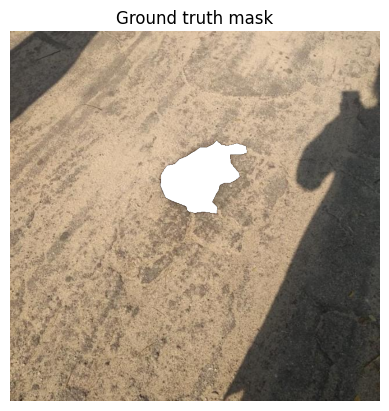

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## Create PyTorch Dataset

In the process of creating a PyTorch dataset, we define a regular dataset structure that organizes the data for the model. Each example within this dataset consists of:

*   Pixel values, representing the image prepared for the model.
*   A bounding box prompt provided in the form of a prompt.
*   A ground truth segmentation mask.

It's important to note that SAM, the model being discussed, is consistently trained using specific "prompts." These prompts can take the form of bounding boxes, points, text, or rudimentary masks. The training objective is for the model to learn and output the appropriate mask corresponding to the given image and prompt.

To facilitate the generation of a bounding box prompt based on the ground truth segmentation, a function is defined below. This function has been adapted from [this source](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29). This step is crucial in preparing the necessary input for the model during the training process.

In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)

  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
import matplotlib.pyplot as plt

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

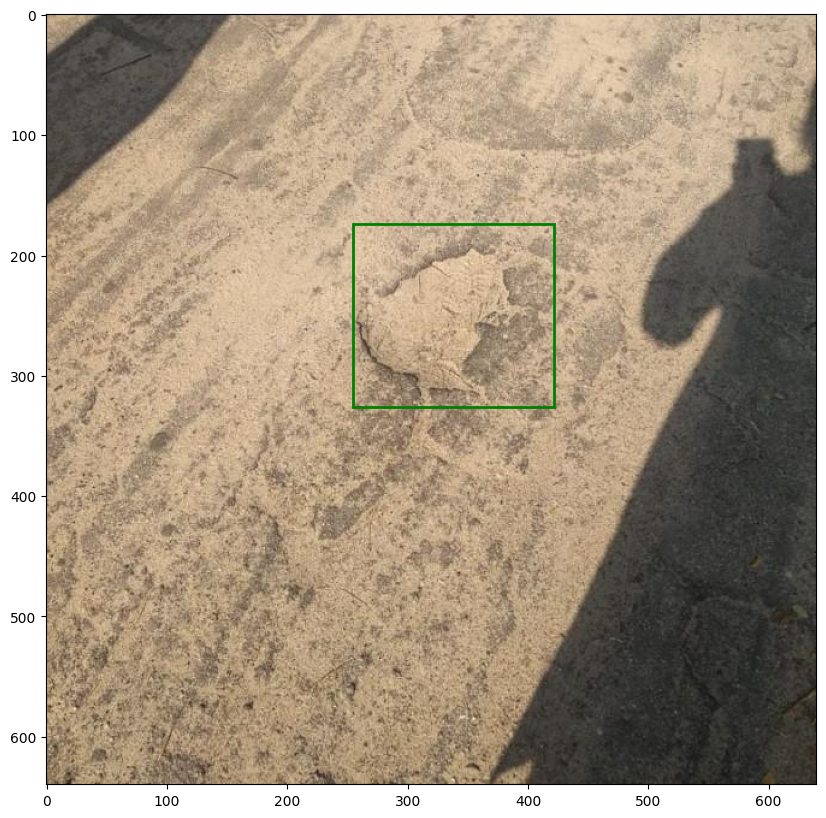

In [ ]:
input_boxes = get_bounding_box(ground_truth_seg)
input_boxes
show_boxes_on_image(image, [input_boxes])

This custom dataset takes a list of samples (each containing an image and a label) and a processor object during initialization. After initialization The `__getitem__` method processes the image and ground truth mask, normalizes the mask, extracts a bounding box prompt, and prepares inputs for the model.
The processed inputs include the image, prompt, and ground truth mask in a dictionary format.

In [ ]:
from torch.utils.data import Dataset
import cv2

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # normalize mask
    ground_truth_mask = ground_truth_mask / 255.0

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
from transformers import SamProcessor

# Load processor from official SAM
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
# Split dataset into training and validation
train_dataset = SAMDataset(dataset=dataset["train"], processor=processor)
validation_dataset = SAMDataset(dataset=dataset["validation"], processor=processor)

In [ ]:
# Here we check shape from sample training dataset
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (640, 640)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 640, 640])


In [ ]:
batch["pixel_values"].shape

torch.Size([2, 3, 1024, 1024])

In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 640, 640])

## Load the model

In [ ]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

## Train the model

In [ ]:
from torch.optim import Adam
import torchvision

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch import nn


num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      predicted_masks = nn.functional.interpolate(predicted_masks,
                size=(640, 640),
                mode='bilinear',
                align_corners=False)

      ground_truth_masks = batch["ground_truth_mask"].float().to(device)

      loss = torchvision.ops.sigmoid_focal_loss(predicted_masks, ground_truth_masks.unsqueeze(1), reduction='mean')

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 40/40 [00:39<00:00,  1.02it/s]


EPOCH: 0
Mean loss: 0.012933115113992245


100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


EPOCH: 1
Mean loss: 0.007018832908943296


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


EPOCH: 2
Mean loss: 0.0060814785014372316


100%|██████████| 40/40 [00:43<00:00,  1.08s/it]


EPOCH: 3
Mean loss: 0.005540281563298777


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]


EPOCH: 4
Mean loss: 0.005291803277214058


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


EPOCH: 5
Mean loss: 0.0050922088179504495


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


EPOCH: 6
Mean loss: 0.004873425260302611


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


EPOCH: 7
Mean loss: 0.004674097143288236


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


EPOCH: 8
Mean loss: 0.004482566786464304


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]

EPOCH: 9
Mean loss: 0.004478737576573621


## Inference

For example inference, we can take random validation image

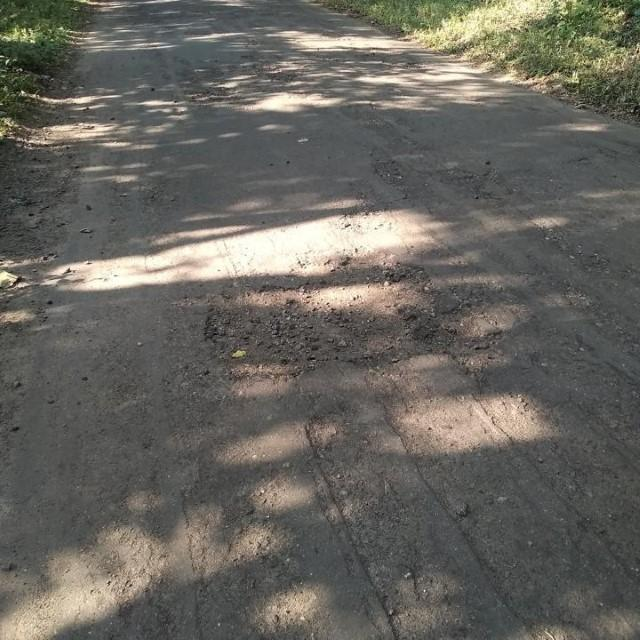

In [ ]:
import numpy as np
from PIL import Image

# let's take a random validation example
idx = 4

# load image
image = dataset["validation"][idx]["image"]
image

In [ ]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset["validation"][idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


Start evaluate model with new image

In [ ]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [ ]:
# apply sigmoid
sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# resize masks to original
sam_seg_prob = nn.functional.interpolate(sam_seg_prob,
                size=(640, 640),
                mode='bilinear',
                align_corners=False)

# convert soft mask to hard mask
sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
sam_segmentation_results = (sam_seg_prob > 0.5).astype(np.uint8)

In [ ]:
sam_segmentation_results.shape

(640, 640)

In [ ]:
ground_truth_mask.shape

(640, 640)

(-0.5, 639.5, 639.5, -0.5)

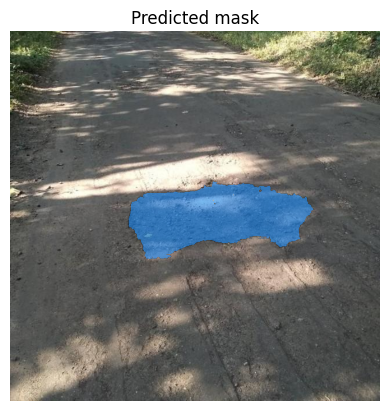

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(sam_segmentation_results, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

(-0.5, 639.5, 639.5, -0.5)

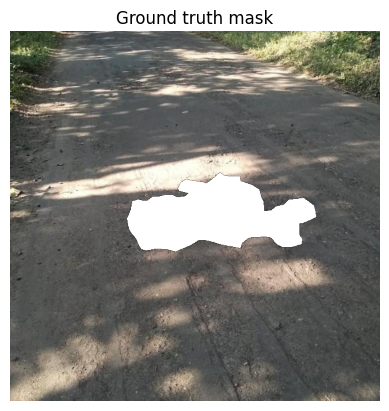

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

# Push the model to Hugging Face Hub

After training finish, you can upload your model to 🤗 Hub and share with community. First login with your keys and use syntax `push_to_hub` below.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.push_to_hub("<your-username>/<repository-name>")

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/adhisetiawan/sam-pothole-segmentation/commit/0340a93bf598eefa7b95d1076acf5db083094b41', commit_message='Upload model', commit_description='', oid='0340a93bf598eefa7b95d1076acf5db083094b41', pr_url=None, pr_revision=None, pr_num=None)